<a href="https://colab.research.google.com/github/Nickqq627/7112029017/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 資料蒐集


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import pandas as pd

# 下載股價數據並計算均線
def get_stock_data():
    ticker = "2330.TW"
    data = yf.download(ticker, start="2019-12-19", end="2024-12-05")
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.date  # 格式化日期
    data.columns = data.columns.droplevel(1)    #去掉第二层索引
    # 計算5日均線和10日均線
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    # 移除包含NaN值的行
    data = data.dropna()
    return data

stock_data = get_stock_data()
print()
print(stock_data.head())

# 將結果保存到新的 CSV 文件
# output_path = "stock_data.csv"  # 輸出文件路徑
# stock_data.to_csv(output_path, index=False)

[*********************100%***********************]  1 of 1 completed


Price        Date   Adj Close  Close   High    Low   Open    Volume    MA5  \
9      2020-01-02  305.257385  339.0  339.0  332.5  332.5  31754120  335.1   
10     2020-01-03  305.707581  339.5  345.0  335.5  344.0  41811268  336.4   
11     2020-01-06  298.954132  332.0  334.5  332.0  333.0  45343057  335.2   
12     2020-01-07  296.703033  329.5  333.0  326.5  332.5  50879181  334.2   
13     2020-01-08  296.703033  329.5  333.0  325.0  325.0  37567748  333.9   

Price    MA10  
9      333.85  
10     334.30  
11     334.60  
12     334.15  
13     333.90  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
news_data = pd.read_csv('/content/drive/MyDrive/news_data.csv')
news_data = news_data[news_data['tag'] == "台股新聞"]
news_data = news_data.drop(['url', 'tag', 'time'], axis=1)
news_data['date'] = pd.to_datetime(news_data['date']).dt.date  # 確保日期格式一致

# 定義行業分類與對應的關鍵字
industry_keywords = {
    '目標': ['台積電'],
    '其他': []
}

# 定義分類函數
def classify_industry(content):
    for industry, keywords in industry_keywords.items():
        for keyword in keywords:
            if keyword in content:
                return industry
    return '其他'  # 若未匹配到任何行業，標註為 "其他"

# 應用分類函數到新聞內容
news_data['industry'] = news_data['content'].apply(classify_industry)

# 統計各行業新聞數量
industry_counts = news_data['industry'].value_counts()

# 顯示統計結果
print("各行業的新聞數量：")
print(industry_counts)
# print(news_data[news_data['industry'] == '目標'])

news_data = news_data[news_data['industry'] == '目標']

output_path = "news_data.csv"  # 輸出文件路徑
news_data.to_csv(output_path, index=False)

各行業的新聞數量：
industry
其他    60755
目標     8493
Name: count, dtype: int64


In [ ]:
from transformers import pipeline
from tqdm import tqdm
import torch

tqdm.pandas()  # 啟用 tqdm 的 pandas 進度條功能
device = 0 if torch.cuda.is_available() else -1
sentiment_analyzer = pipeline("text-classification", model="yiyanghkust/finbert-tone-chinese",
                max_length=512,
                truncation=True,
                device=device)

def analyze_sentiment_of_financial_news(text):

    sentiment = sentiment_analyzer(text)
    label = sentiment[0]['label']  # 提取情緒標籤
    score = sentiment[0]['score']  # 提取情緒分數

    # 將標籤轉換為數值
    if label == 'Positive':
        sentiment_value = 1
    elif label == 'Neutral':
        sentiment_value = 0
    elif label == 'Negative':
        sentiment_value = -1
    else:
        sentiment_value = None  # 若出現未知標籤，設置為 None

    return sentiment_value, score

news_data[['sentiment', 'score']] = news_data['content'].progress_apply(
    lambda x: pd.Series(analyze_sentiment_of_financial_news(x))
)

# 統計每個標籤的數量
sentiment_counts = news_data['sentiment'].value_counts()

# 打印每個情緒值的數量
print("Sentiment Counts:")
print(f"1 (Positive): {sentiment_counts.get(1, 0)}")
print(f"0 (Neutral): {sentiment_counts.get(0, 0)}")
print(f"-1 (Negative): {sentiment_counts.get(-1, 0)}")

# # 測試文本 (例如一篇中文財經新聞)
# text = '市場正在觀察台積電和鴻海的季度財報，以評估未來的發展趨勢。'

# # 分析情緒
# result = analyze_sentiment_of_financial_news(text)

# # 輸出情緒分析結果
# print(f"情緒分析結果:\n{result}")

news_data = news_data.drop(['title', 'content', 'industry'], axis=1)
output_path = "sentiment_data.csv"  # 輸出文件路徑
news_data.to_csv(output_path, index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 8493/8493 [04:32<00:00, 31.14it/s]

Sentiment Counts:
1 (Positive): 5611
0 (Neutral): 1914
-1 (Negative): 968


In [ ]:
# 聚合新聞情緒
aggregated_news = news_data.groupby('date').agg(
    avg_sentiment=('sentiment', 'mean'),  # 平均情緒
    negative_count=('sentiment', lambda x: (x == -1).sum()), # 負面數量
).reset_index()

# 合併股價數據與新聞情緒數據
merged_data = pd.merge(stock_data, aggregated_news, how='left', left_on='Date', right_on='date')

# 填補空值（如果某天沒有新聞）
merged_data.fillna({
    'avg_sentiment': 0,
}, inplace=True)

merged_data = merged_data[['Date','Close','MA5','MA10','avg_sentiment']]
print(merged_data.head())
output_path = "close_MA_sentiment.csv"  # 輸出文件路徑
merged_data.to_csv(output_path, index=False)

         Date  Close    MA5    MA10  avg_sentiment
0  2020-01-02  339.0  335.1  333.85            1.0
1  2020-01-03  339.5  336.4  334.30            1.0
2  2020-01-06  332.0  335.2  334.60            0.5
3  2020-01-07  329.5  334.2  334.15            1.0
4  2020-01-08  329.5  333.9  333.90            0.0


# 資料前處理



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input

merged_data = pd.read_csv('/content/close_MA_sentiment.csv')

# 1. 數據預處理
# 將股價數據和新聞情緒數據合併並標準化
scaler = MinMaxScaler(feature_range=(0, 1))
merged_data['Close_scaled'] = scaler.fit_transform(merged_data['Close'].values.reshape(-1, 1))
merged_data['MA5_scaled'] = scaler.fit_transform(merged_data['MA5'].values.reshape(-1, 1))
merged_data['MA10_scaled'] = scaler.fit_transform(merged_data['MA10'].values.reshape(-1, 1))


# 設定訓練集和測試集，80% 訓練，20% 測試
train_size = int(len(merged_data) * 0.8)
train_data, test_data = merged_data[:train_size], merged_data[train_size:]

# 函數：創建 LSTM 的數據格式
def create_lstm_data(data, time_steps=20):
    x_data, y_data = [], []
    for i in range(time_steps, len(data)):
        x_data.append(data.iloc[i-time_steps:i][
            ['Close_scaled', 'avg_sentiment', 'MA5_scaled', 'MA10_scaled']
        ].values)
        y_data.append(data.iloc[i]['Close_scaled'])
    return np.array(x_data), np.array(y_data)

# 創建訓練和測試數據
X_train, y_train = create_lstm_data(train_data)
X_test, y_test = create_lstm_data(test_data)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input

merged_data = pd.read_csv('/content/close_MA_sentiment.csv')

# 1. 數據預處理
# 將股價數據和新聞情緒數據合併並標準化
scaler = MinMaxScaler(feature_range=(0, 1))
merged_data['Close_scaled'] = scaler.fit_transform(merged_data['Close'].values.reshape(-1, 1))
merged_data['MA5_scaled'] = scaler.fit_transform(merged_data['MA5'].values.reshape(-1, 1))
merged_data['MA10_scaled'] = scaler.fit_transform(merged_data['MA10'].values.reshape(-1, 1))


# 設定訓練集和測試集，80% 訓練，20% 測試
train_size = int(len(merged_data) * 0.8)
train_data, test_data = merged_data[:train_size], merged_data[train_size:]

# 函數：創建 LSTM 的數據格式
def create_lstm_data(data, time_steps=20):
    x_data_1, x_data_2, y_data = [], [], []
    for i in range(time_steps, len(data)):
        # 第一分支資料：股價 + 情緒數據
        x_data_1.append(data.iloc[i-time_steps:i][['Close_scaled', 'avg_sentiment']].values)

        # 第二分支資料：股價 + 移動平均數據
        x_data_2.append(data.iloc[i-time_steps:i][['Close_scaled', 'MA5_scaled', 'MA10_scaled']].values)

        # 預測目標：收盤價
        y_data.append(data.iloc[i]['Close_scaled'])

    return np.array(x_data_1), np.array(x_data_2), np.array(y_data)

# 創建訓練和測試數據
X_train_1, X_train_2, y_train = create_lstm_data(train_data)
X_test_1, X_test_2, y_test = create_lstm_data(test_data)

# 前期融合

In [ ]:
# 2. 模型構建
# 前期融合：股價數據與情緒數據融合，丟進 LSTM 再接入 DNN
def build_early_fusion_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 3. 訓練模型
early_fusion_model = build_early_fusion_model()
early_fusion_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# 4. 預測並反標準化
predicted_stock_price = early_fusion_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


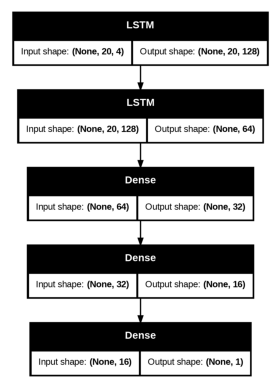

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(early_fusion_model, to_file='early_fusion_model.png', show_shapes=True)

# Display the plot using matplotlib
img = plt.imread('early_fusion_model.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

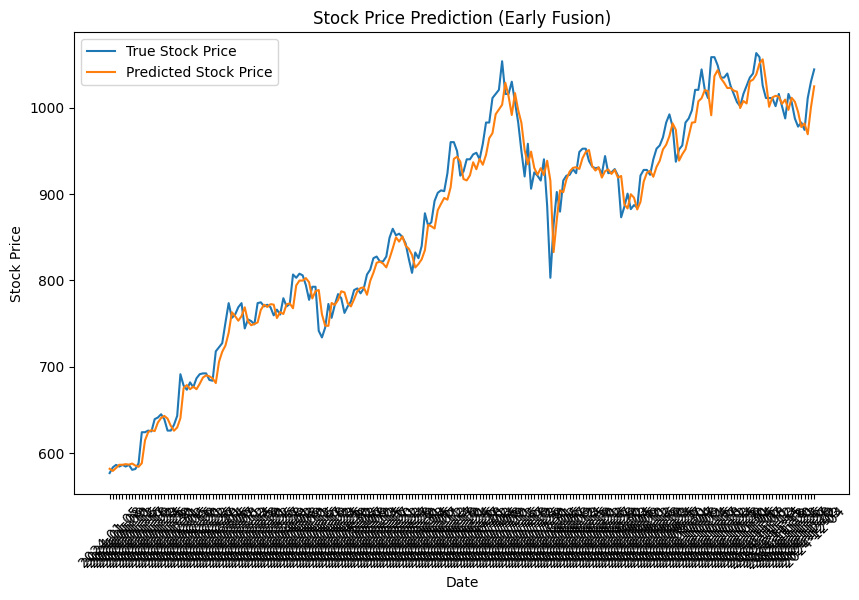

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'][len(test_data) - len(y_test):], y_test, label='True Stock Price')
plt.plot(test_data['Date'][len(test_data) - len(predicted_stock_price):], predicted_stock_price, label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Early Fusion)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. 計算均方誤差 (MSE)
mse = mean_squared_error(y_test, predicted_stock_price)
print(f'Mean Squared Error (MSE): {mse}')

# 2. 計算均方根誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 3. 計算平均絕對誤差 (MAE)
mae = mean_absolute_error(y_test, predicted_stock_price)
print(f'Mean Absolute Error (MAE): {mae}')

# 4. 計算 R² (決定係數)
r2 = r2_score(y_test, predicted_stock_price)
print(f'R² (R-squared): {r2}')

# 5. 計算平均絕對百分比誤差 (MAPE)
mape = np.mean(np.abs((y_test - predicted_stock_price) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 413.13613536733874
Root Mean Squared Error (RMSE): 20.325750548684265
Mean Absolute Error (MAE): 14.401923261266399
R² (R-squared): 0.9761165421244974
Mean Absolute Percentage Error (MAPE): 1.6514444951833178%


# 中期融合

In [ ]:
from tensorflow.keras.layers import Concatenate

# 修改模型
def build_mid_fusion_model():
    # 股價 + 情緒數據分支
    stock_sentiment_input = Input(shape=(X_train_1.shape[1], X_train_1.shape[2]), name="stock_sentiment_input")
    stock_sentiment_lstm = LSTM(128, return_sequences=True)(stock_sentiment_input)
    stock_sentiment_lstm = LSTM(64, return_sequences=False)(stock_sentiment_lstm)
    stock_sentiment_features = stock_sentiment_lstm

    # 股價 + 移動平均數據分支
    stock_moving_avg_input = Input(shape=(X_train_2.shape[1], X_train_2.shape[2]), name="stock_moving_avg_input")
    stock_moving_avg_lstm = LSTM(128, return_sequences=True)(stock_moving_avg_input)
    stock_moving_avg_lstm = LSTM(64, return_sequences=False)(stock_moving_avg_lstm)
    stock_moving_avg_features = stock_sentiment_lstm

    # 融合特徵向量
    merged = Concatenate()([stock_sentiment_features, stock_moving_avg_features])
    merged = Dense(64)(merged)
    merged = Dense(32)(merged)
    merged = Dense(16)(merged)
    output = Dense(1)(merged)

    # 建立模型
    model = Model(inputs=[stock_sentiment_input, stock_moving_avg_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 構建模型
mid_fusion_model = build_mid_fusion_model()

# 模型訓練
history = mid_fusion_model.fit(
    [X_train_1, X_train_2], y_train,  # 使用兩個不同的資料集
    epochs=100,
    batch_size=32,
    verbose=0
)

# 預測
mid_fusion_predictions = mid_fusion_model.predict([X_test_1, X_test_2])
mid_fusion_predictions = scaler.inverse_transform(mid_fusion_predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


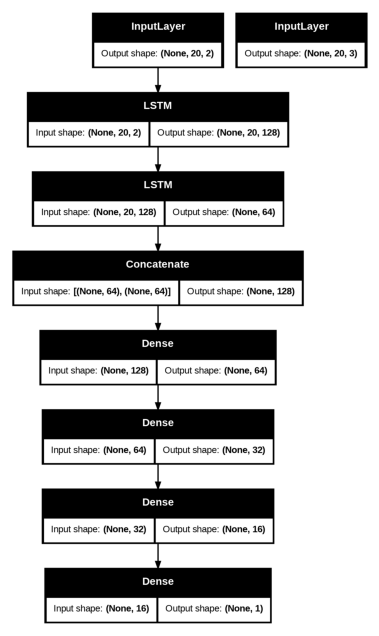

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(mid_fusion_model, to_file='mid_fusion_predictions.png', show_shapes=True)

# Display the plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 8))
img = plt.imread('mid_fusion_predictions.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

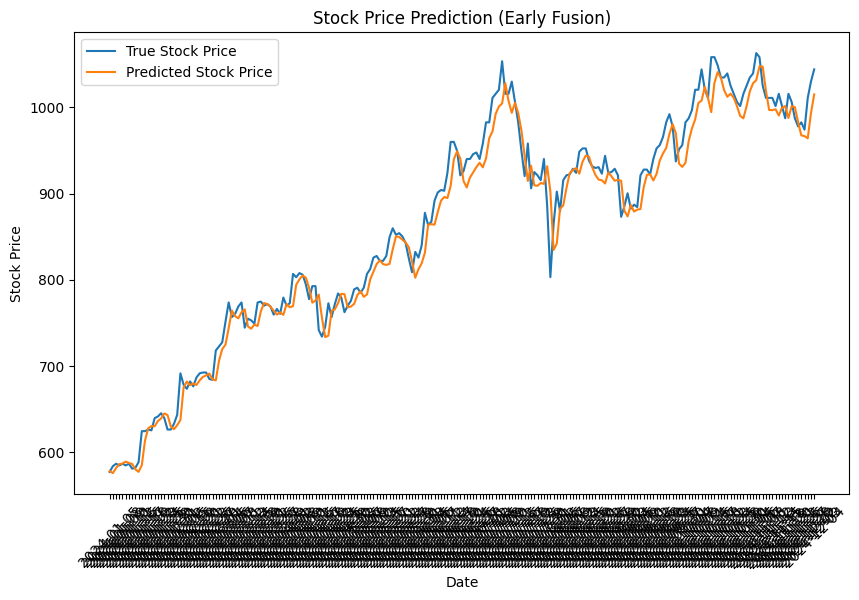

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'][len(test_data) - len(y_test):], y_test, label='True Stock Price')
plt.plot(test_data['Date'][len(test_data) - len(mid_fusion_predictions):], mid_fusion_predictions, label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Early Fusion)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. 計算均方誤差 (MSE)
mse = mean_squared_error(y_test, mid_fusion_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 2. 計算均方根誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 3. 計算平均絕對誤差 (MAE)
mae = mean_absolute_error(y_test, mid_fusion_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# 4. 計算 R² (決定係數)
r2 = r2_score(y_test, mid_fusion_predictions)
print(f'R² (R-squared): {r2}')

# 5. 計算平均絕對百分比誤差 (MAPE)
mape = np.mean(np.abs((y_test - mid_fusion_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 459.4865574702127
Root Mean Squared Error (RMSE): 21.435637556886725
Mean Absolute Error (MAE): 15.83534472263491
R² (R-squared): 0.9734370177279653
Mean Absolute Percentage Error (MAPE): 1.8020352602965632%


# 後期融合

In [ ]:
# 創建 LSTM 分支
def build_lstm_branch(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(1))  # 獨立預測結果
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 為股價 + 情緒數據創建 LSTM 模型
stock_sentiment_model = build_lstm_branch((X_train_1.shape[1], X_train_1.shape[2]))
stock_sentiment_model.compile(optimizer='adam', loss='mean_squared_error')

# 為股價 + 移動平均數據創建 LSTM 模型
stock_moving_avg_model = build_lstm_branch((X_train_2.shape[1], X_train_2.shape[2]))
stock_moving_avg_model.compile(optimizer='adam', loss='mean_squared_error')

# 分別訓練兩個模型
stock_sentiment_model.fit(X_train_1, y_train, epochs=100, batch_size=32, verbose=0)
stock_moving_avg_model.fit(X_train_2, y_train, epochs=100, batch_size=32, verbose=0)

# 預測
stock_sentiment_predictions = stock_sentiment_model.predict(X_test_1)
stock_moving_avg_predictions = stock_moving_avg_model.predict(X_test_2)

# 後期融合（加權平均，權重可調整）
final_predictions = 0.5 * stock_sentiment_predictions + 0.5 * stock_moving_avg_predictions
final_predictions = scaler.inverse_transform(final_predictions)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(stock_lstm_model, to_file='late_fusion_model.png', show_shapes=True)

# Display the plot using matplotlib
img = plt.imread('late_fusion_model.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

NameError: name 'stock_lstm_model' is not defined

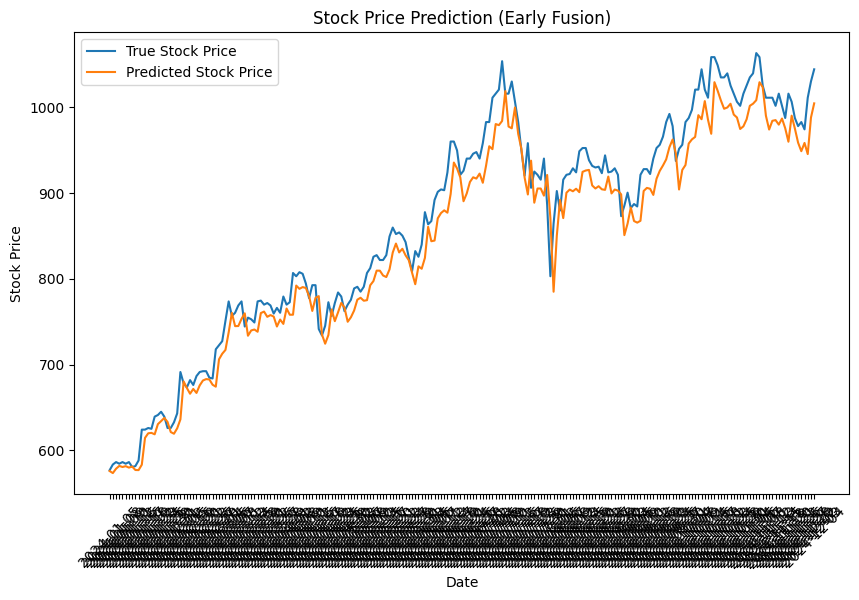

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'][len(test_data) - len(y_test):], y_test, label='True Stock Price')
plt.plot(test_data['Date'][len(test_data) - len(final_predictions):], final_predictions, label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Early Fusion)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. 計算均方誤差 (MSE)
mse = mean_squared_error(y_test, final_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# 2. 計算均方根誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 3. 計算平均絕對誤差 (MAE)
mae = mean_absolute_error(y_test, final_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# 4. 計算 R² (決定係數)
r2 = r2_score(y_test, final_predictions)
print(f'R² (R-squared): {r2}')

# 5. 計算平均絕對百分比誤差 (MAPE)
mape = np.mean(np.abs((y_test - final_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 872.7054434002858
Root Mean Squared Error (RMSE): 29.541588369623693
Mean Absolute Error (MAE): 24.377364223993347
R² (R-squared): 0.9495487760308357
Mean Absolute Percentage Error (MAPE): 2.736441704163556%


# 單模態


In [ ]:
def build_single_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 3. 訓練模型
single_model = build_single_model()
single_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# 4. 預測並反標準化
predicted_stock_price = single_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


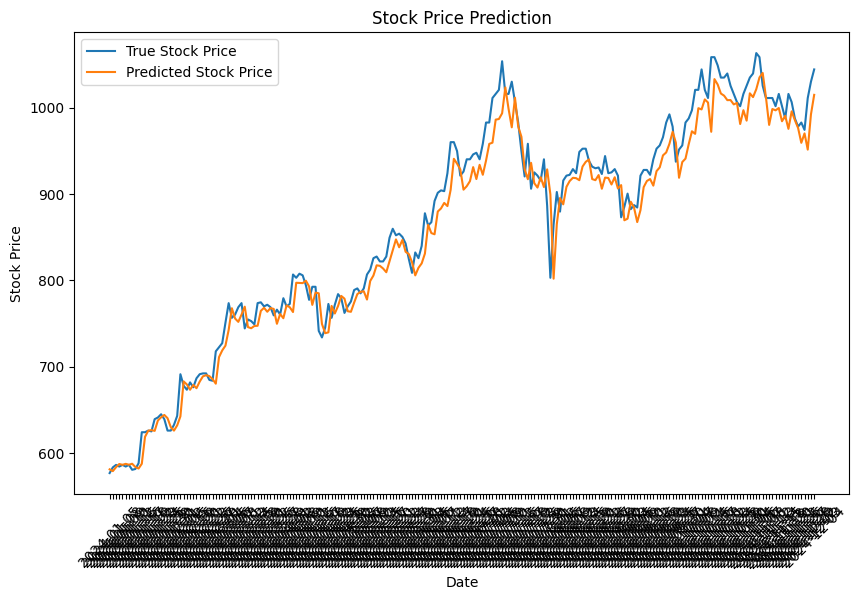

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. 可視化預測結果
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'][len(test_data) - len(y_test):], y_test, label='True Stock Price')
plt.plot(test_data['Date'][len(test_data) - len(predicted_stock_price):], predicted_stock_price, label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. 計算均方誤差 (MSE)
mse = mean_squared_error(y_test, predicted_stock_price)
print(f'Mean Squared Error (MSE): {mse}')

# 2. 計算均方根誤差 (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 3. 計算平均絕對誤差 (MAE)
mae = mean_absolute_error(y_test, predicted_stock_price)
print(f'Mean Absolute Error (MAE): {mae}')

# 4. 計算 R² (決定係數)
r2 = r2_score(y_test, predicted_stock_price)
print(f'R² (R-squared): {r2}')

# 5. 計算平均絕對百分比誤差 (MAPE)
mape = np.mean(np.abs((y_test - predicted_stock_price) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 570.2838258712258
Root Mean Squared Error (RMSE): 23.88061611163384
Mean Absolute Error (MAE): 18.128189903923154
R² (R-squared): 0.9670318121164458
Mean Absolute Percentage Error (MAPE): 2.0350564134417803%


# 資料分析

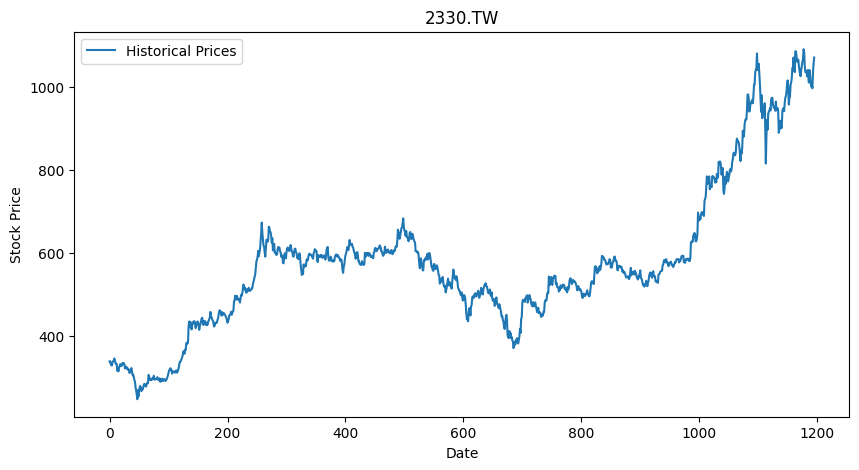

In [ ]:
# 只使用 'Close' 收盤價
stock_prices = stock_data['Close']

# 畫出預測結果
plt.figure(figsize=(10, 5))
plt.plot(stock_prices,  label='Historical Prices')
plt.title('2330.TW')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input

merged_data = pd.read_csv('/content/close_MA_sentiment.csv')

# 1. 數據預處理
# 將股價數據和新聞情緒數據合併並標準化
scaler = MinMaxScaler(feature_range=(0, 1))
merged_data['Close_scaled'] = scaler.fit_transform(merged_data['Close'].values.reshape(-1, 1))
merged_data['MA5_scaled'] = scaler.fit_transform(merged_data['MA5'].values.reshape(-1, 1))
merged_data['MA10_scaled'] = scaler.fit_transform(merged_data['MA10'].values.reshape(-1, 1))


# 設定訓練集和測試集，80% 訓練，20% 測試
train_size = int(len(merged_data) * 0.8)
train_data, test_data = merged_data[:train_size], merged_data[train_size:]

# 函數：創建 LSTM 的數據格式
def create_lstm_data(data, time_steps=20):
    x_data, y_data = [], []
    for i in range(time_steps, len(data)):
        x_data.append(data.iloc[i-time_steps:i][
            ['Close_scaled', 'avg_sentiment', 'MA5_scaled', 'MA10_scaled']
        ].values)
        y_data.append(data.iloc[i]['Close_scaled'])
    return np.array(x_data), np.array(y_data)

# 創建訓練和測試數據
X_train, y_train = create_lstm_data(train_data)
X_test, y_test = create_lstm_data(test_data)